Following example at:

https://github.com/lsst/source_injection/blob/tickets/DM-39728/examples/si_demo_dc2_visit.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import artpop
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.ndimage import gaussian_filter
from dustmaps.sfd import SFDQuery

from lsst.daf.butler import Butler, DimensionUniverse, DatasetType, CollectionType
from lsst.daf.butler.registry import MissingCollectionError
import lsst.afw.display as afwDisplay
from lsst.source.injection.inject_visit import VisitInjectConfig,VisitInjectTask
from lsst.source.injection import ingest_injection_catalog

afwDisplay.setDefaultBackend('matplotlib')

Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-6.0.0/Linux64/dustmaps_cachedata/g41a3ec361e+f0a1800e64/config/.dustmapsrc


In [2]:
# Import tasks from the LSST Science Pipelines for reprocessing images
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.calibrate import CalibrateTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask

# Import LSST Science Pipelines packages (see pipelines.lsst.io)
import lsst.daf.base as dafBase
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
import lsst.geom as geom

In [3]:
config = 'dp02'
collections = '2.2i/runs/DP0.2'
butler = Butler(config, collections=collections)

In [65]:
tract = 3828

calexp_g_DatasetRefs = sorted(list(set(
        butler.registry.queryDatasets(
        'calexp',
        where=f"instrument='LSSTCam-imSim' AND skymap='DC2' AND tract={tract} AND detector=1 AND band='g'",
))))

print(f'Identified {len(calexp_g_DatasetRefs)} calexp DatasetRefs')

display(calexp_g_DatasetRefs[5])

dataId_g = calexp_g_DatasetRefs[5].dataId

print(f"{dataId_g = }")

Identified 19 calexp DatasetRefs


DatasetRef(DatasetType('calexp', {band, instrument, detector, physical_filter, visit_system, visit}, ExposureF), {instrument: 'LSSTCam-imSim', detector: 1, visit: 430094, ...}, id=64b1a4a9-a441-4d22-9557-034f31922e01, run='2.2i/runs/DP0.2/v23_0_0_rc5/PREOPS-905/20211220T180923Z')

dataId_g = {instrument: 'LSSTCam-imSim', detector: 1, visit: 430094, ...}


In [66]:
calexp_g = butler.get('calexp', dataId=dataId_g)

display(calexp)

In [67]:
wcs = calexp_g.getWcs()
bbox = calexp_g.getBBox()
boxcen = bbox.getCenter()
cen = wcs.pixelToSky(boxcen)
sc_cen = SkyCoord(ra=cen[0].asDegrees()*u.deg, dec=cen[1].asDegrees()*u.deg)

In [68]:
tract = 3828

calexp_i_DatasetRefs = sorted(list(set(
        butler.registry.queryDatasets(
        'calexp',
        where=f"instrument='LSSTCam-imSim' AND skymap='DC2' AND tract={tract} AND detector=1 AND band='i'",
))))

print(f'Identified {len(calexp_i_DatasetRefs)} calexp DatasetRefs')

Identified 33 calexp DatasetRefs


In [74]:
racen = []
deccen = []
sepcen = []

for ref in calexp_i_DatasetRefs:
    dataId = ref.dataId
    bbox_tmp = butler.get('calexp.bbox', dataId=dataId)
    wcs_tmp = butler.get('calexp.wcs', dataId=dataId)
    radec_cen = wcs_tmp.pixelToSky(bbox_tmp.getCenterX(), bbox_tmp.getCenterY())
    sc_cen_tmp = SkyCoord(ra=radec_cen[0].asDegrees()*u.deg, dec=radec_cen[1].asDegrees()*u.deg)
    racen.append(radec_cen[0].asDegrees())
    deccen.append(radec_cen[0].asDegrees())
    sepcen.append(sc_cen_tmp.separation(sc_cen).arcmin)

racen = np.array(racen)
deccen = np.array(deccen)
sepcen = np.array(sepcen)

In [77]:
print('Separation from center of nearest i-band image: ', np.min(sepcen), ' arcmin')

Separation from center of nearest i-band image:  8.680688658363604  arcmin


In [80]:
dataId_i = calexp_i_DatasetRefs[np.argmin(sepcen)].dataId
print(dataId_i)

calexp_i = butler.get('calexp', dataId=dataId_i)

{instrument: 'LSSTCam-imSim', detector: 1, visit: 397279, ...}


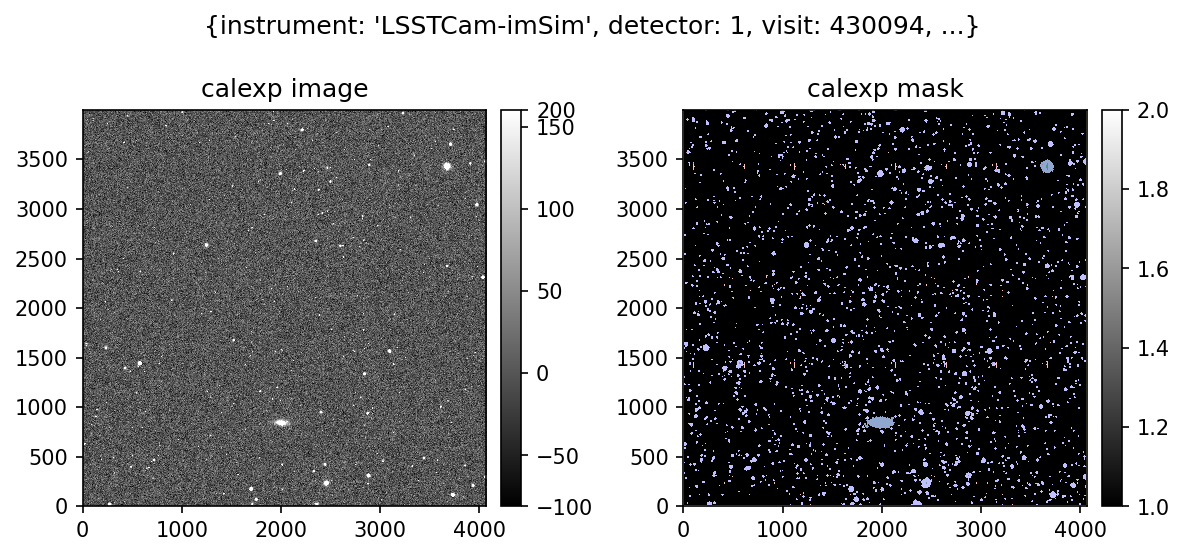

In [107]:
Q = 10

plot_calexp_g = calexp_g.clone()
plot_calexp_i = calexp_i.clone()
# plot_calexp.image.array = gaussian_filter(calexp.image.array, sigma=3)

fig, ax = plt.subplots(1, 2, figsize=(8, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
#display0.scale('asinh', min=-5/Q, max=25/Q, Q=Q)
display0.mtv(plot_calexp_g.image)
plt.title('calexp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', min=1, max=2)
display1.mtv(plot_calexp_g.mask)
plt.title('calexp mask')

plt.suptitle(str(dataId_g), y=0.8)
plt.tight_layout()
plt.show()

Install [Artpop](https://artpop.readthedocs.io/en/latest/index.html)

pip install --user artpop

In [83]:
# use this random state for reproducibility
rand = np.random.RandomState(100)

# create old, metal-poor SSP source at 15 kpc

ssp = artpop.MISTPlummerSSP(
    log_age = 10.1,          # log of age in years
    feh = -2,             # metallicity [Fe/H]
    total_mass = 1.0e3,   # total mass in M_Sun
    distance = 15.0*u.kpc, # distance in kpc
    scale_radius = 10.0*u.pc, # scale radius in pc
    phot_system = 'LSST', # photometric system(s)
    imf = 'kroupa',       # default imf
    random_state = rand,   # random state for reproducibility
    xy_dim = 3999,
    pixel_scale = 0.2,
    mag_limit = 25.0,
    mag_limit_band = 'LSST_g',
)


In [84]:
np.log10(12.5e9)

10.096910013008056

In [85]:
ssp.mags

LSST_u,LSST_g,LSST_r,LSST_i,LSST_z,LSST_y
float64,float64,float64,float64,float64,float64
25.72674308788548,24.19183620355924,23.471333859534255,23.164028464462852,23.026804275126622,22.9476524391688
24.955550995531596,23.644436296913952,23.020097723910553,22.758335973530308,22.64612203894266,22.58487897821103
21.985701037454707,21.31731808672115,21.056530734237327,20.971422044309474,20.962007136309097,20.97128214880932
26.79192378229275,24.98832854217497,24.13406158055675,23.76579673303729,23.594092696074622,23.493272539088075
26.39812961545367,24.68610579375875,23.88089300641709,23.534736043880017,23.37549181086751,23.282138311878434
23.326323122280513,22.463527086529467,22.046697116479322,21.882200088135033,21.82637180626668,21.805210779387917
26.344354383309437,24.64503520597674,23.846395757843013,23.50321311277105,23.345655674270326,23.253319178971456
23.99214970857625,22.961894998491246,22.45783348213657,22.253291156922174,22.174374614975353,22.13671595417911
21.551936162099576,20.897066020544116,20.675990842649444,20.61262652421825,20.616612829902813,20.633195797913714


In [86]:
wcs = calexp.getWcs()
bbox = calexp.getBBox()
boxcen = bbox.getCenter()
xcoords = ssp.x + boxcen.x - 2000
ycoords = ssp.y + boxcen.y - 2000
radec_coords = wcs.pixelToSkyArray(xcoords, ycoords, degrees=True)

In [87]:
# Add extinction
# see https://github.com/rubin-dp0/delegate-contributions-dp02/blob/db7d06ba6203faa15732c5368ff6e52ea53c5796/MWhalo_density/Milky_Way_halo_density.ipynb#L64

# set the A_lamba/E(B-V) values for the six ugrizy LSST filters
band_a_ebv = np.array([4.812, 3.643, 2.699, 2.063, 1.578, 1.313])

coords = SkyCoord(radec_coords[0], radec_coords[1],
                  unit='deg', frame='icrs')

sfd = SFDQuery()
ebvvec = sfd(coords)

u_ext = ssp.mags['LSST_u'] + ebvvec*band_a_ebv[0]
g_ext = ssp.mags['LSST_g'] + ebvvec*band_a_ebv[1]
r_ext = ssp.mags['LSST_r'] + ebvvec*band_a_ebv[2]
i_ext = ssp.mags['LSST_i'] + ebvvec*band_a_ebv[3]
z_ext = ssp.mags['LSST_z'] + ebvvec*band_a_ebv[4]

In [88]:
si_cat_stars_g = Table({'injection_id': np.arange(len(ssp.mags)),
                        'ra': radec_coords[0], 'dec': radec_coords[1],
                        'source_type': ['DeltaFunction']*len(ssp.mags),
                        'g_mag': g_ext, 'i_mag': i_ext,
                        'mag': g_ext,
                       })
#                      'g_mag': ssp.mags['LSST_g'], 'i_mag': ssp.mags['LSST_i'],
#                      'mag': ssp.mags['LSST_g'],

si_cat_stars_i = Table({'injection_id': np.arange(len(ssp.mags)),
                        'ra': radec_coords[0], 'dec': radec_coords[1],
                        'source_type': ['DeltaFunction']*len(ssp.mags),
                        'g_mag': g_ext, 'i_mag': i_ext,
                        'mag': i_ext,
                       })

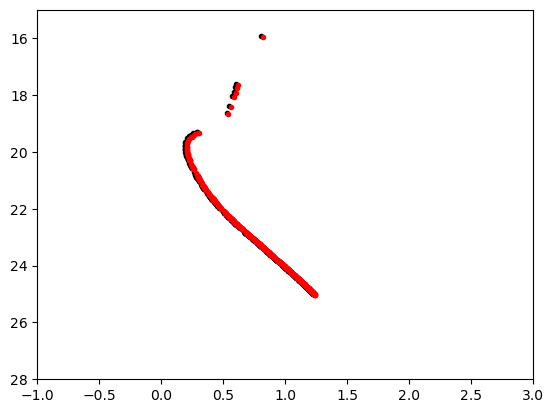

In [89]:
plt.plot(ssp.mags['LSST_g']-ssp.mags['LSST_i'], ssp.mags['LSST_g'], 'k.')
plt.plot(g_ext-i_ext, g_ext, 'r.')
plt.ylim(28, 15)
plt.xlim(-1, 3)
plt.show()

In [90]:
writeable_butler =  Butler(config, writeable=True)

In [91]:
si_input_collection = 'u/jcarlin/si_demo'

try:
    writeable_butler.removeRuns([si_input_collection])
except MissingCollectionError:
    print('Writing into a new RUN collection')
    pass
else:
    print('Prior RUN collection located and successfully removed')

Prior RUN collection located and successfully removed


In [92]:
dataset_refs_g = ingest_injection_catalog(
    writeable_butler=writeable_butler,
    table=si_cat_stars_g,
    band=dataId_g['band'],
    output_collection=si_input_collection,
    dataset_type_name='injection_catalog'
)

print(f'{dataset_refs_g = }')

dataset_refs_i = ingest_injection_catalog(
    writeable_butler=writeable_butler,
    table=si_cat_stars_i,
    band=dataId_i['band'],
    output_collection=si_input_collection,
    dataset_type_name='injection_catalog'
)

print(f'{dataset_refs_i = }')

dataset_refs_g = [DatasetRef(DatasetType('injection_catalog', {band, htm7}, ArrowAstropy), {band: 'g', htm7: 147086}, id=f240769c-de3d-4ddf-a637-a7ef030d038f, run='u/jcarlin/si_demo'), DatasetRef(DatasetType('injection_catalog', {band, htm7}, ArrowAstropy), {band: 'g', htm7: 147087}, id=9c97b96a-6271-40e2-bc5e-b71f581a0bb3, run='u/jcarlin/si_demo')]


dataset_refs_i = [DatasetRef(DatasetType('injection_catalog', {band, htm7}, ArrowAstropy), {band: 'i', htm7: 147086}, id=7a69c8cf-b5a2-480f-8497-76b1bb3a0616, run='u/jcarlin/si_demo'), DatasetRef(DatasetType('injection_catalog', {band, htm7}, ArrowAstropy), {band: 'i', htm7: 147087}, id=39674aca-792c-4526-b361-b81856246bfd, run='u/jcarlin/si_demo')]


In [95]:
butler = Butler(config, collections=collections)

tables_g = [butler.get(ref) for ref in dataset_refs_g]
tables_i = [butler.get(ref) for ref in dataset_refs_i]

In [96]:
inject_config = VisitInjectConfig()

display(inject_config)

inject_task = VisitInjectTask(config=inject_config)

lsst.source.injection.inject_visit.VisitInjectConfig(saveMetadata=True, saveLogOutput=True, process_all_data_ids=False, trim_padding=100, mask_plane_name='INJECTED', calib_flux_radius=12.0, fits_alignment='pixel', stamp_prefix='', col_ra='ra', col_dec='dec', col_mag='mag', col_source_type='source_type', col_stamp='stamp', col_draw_size='draw_size', col_trail_length='trail_length', connections={'injection_catalogs': '{injection_prefix}catalog', 'visit_summary': 'finalVisitSummary', 'input_exposure': 'calexp', 'output_exposure': '{injected_prefix}calexp', 'output_catalog': '{injected_prefix}calexp_catalog', 'injection_prefix': 'injection_', 'injected_prefix': 'injected_'}, external_psf=False, external_photo_calib=False, external_wcs=False)

In [97]:
inject_output_g = inject_task.run(
    injection_catalogs=tables_g,
    input_exposure=calexp_g.clone(),
    psf=calexp_g.getPsf(),
    photo_calib=calexp_g.getPhotoCalib(),
    wcs=calexp_g.getWcs()
)

In [98]:
inject_output_i = inject_task.run(
    injection_catalogs=tables_i,
    input_exposure=calexp_i.clone(),
    psf=calexp_i.getPsf(),
    photo_calib=calexp_i.getPhotoCalib(),
    wcs=calexp_i.getWcs()
)

In [100]:
si_calexp_g = inject_output_g.output_exposure
si_cat_out_g = inject_output_g.output_catalog
si_calexp_i = inject_output_i.output_exposure
si_cat_out_i = inject_output_i.output_catalog

display(si_cat_out_g[:5])

injection_id,injection_flag,injection_draw_size,ra,dec,source_type,g_mag,i_mag,mag
int64,int64,int64,float64,float64,str13,float64,float64,float64
0,0,30,56.386819425989316,-37.37200340443776,DeltaFunction,24.233131571783623,23.18741368187616,24.233131571783623
1,0,30,56.41848575562872,-37.291260679102955,DeltaFunction,23.679991868231625,22.77847079320182,23.679991868231625
2,0,30,56.41873085704114,-37.27770559165473,DeltaFunction,21.352197797246426,20.991174129518367,21.352197797246426
3,0,30,56.37656126361776,-37.25675364638485,DeltaFunction,25.02366078233925,23.78580508282846,25.02366078233925
4,0,30,56.368690525362105,-37.295229974383425,DeltaFunction,24.72346432362449,23.555891863176853,24.72346432362449


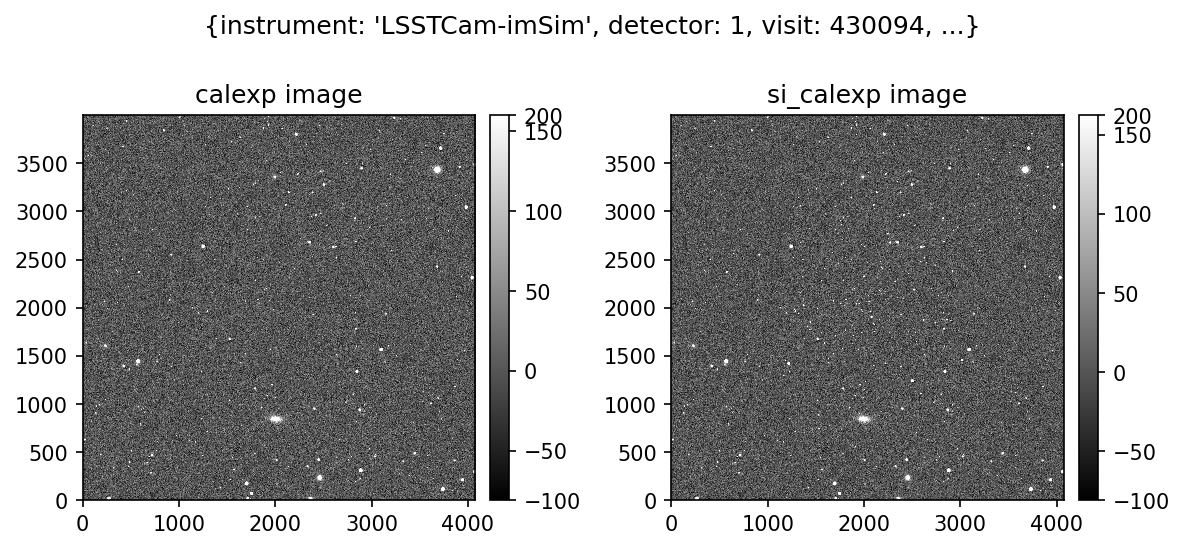

In [108]:
Q = 10

plot_si_calexp_g = si_calexp_g.clone()
plot_si_calexp_i = si_calexp_i.clone()
# plot_si_calexp.image.array = gaussian_filter(si_calexp.image.array, sigma=3)

fig, ax = plt.subplots(1, 2, figsize=(8, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale("linear", "zscale")
#display0.scale('asinh', min=-5/Q, max=25/Q, Q=Q)
display0.mtv(plot_calexp_g.image)
plt.title('calexp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale("linear", "zscale")
# display1.scale('asinh', min=-5/Q, max=25/Q, Q=Q)
display1.mtv(plot_si_calexp_g.image)
plt.title('si_calexp image')

plt.suptitle(str(dataId_g), y=0.8)
plt.tight_layout()
plt.show()

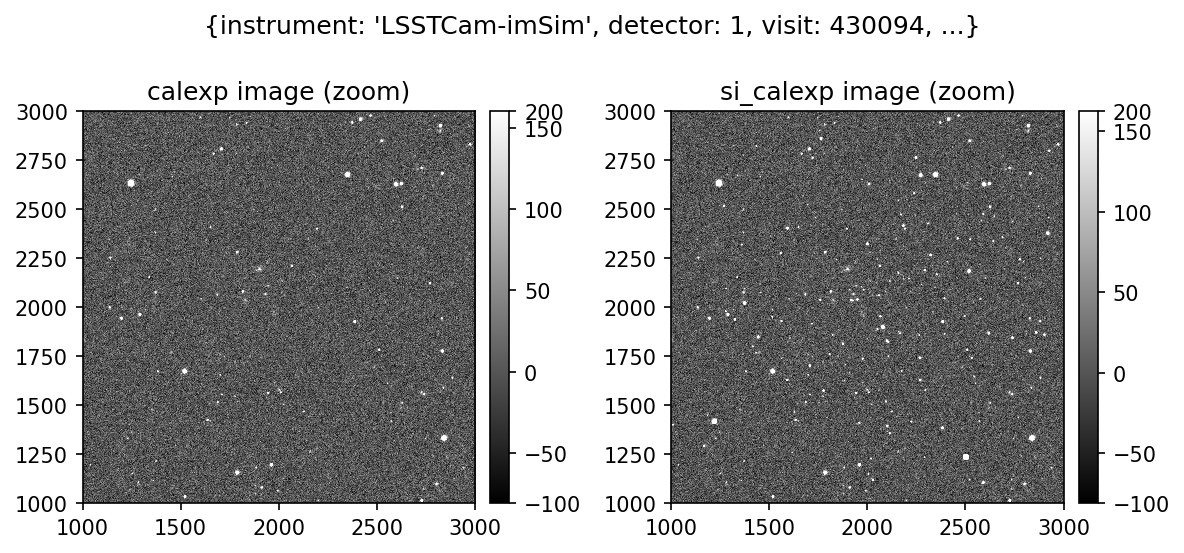

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale("linear", "zscale")
display0.mtv(plot_calexp_g.image)
plt.title('calexp image (zoom)')
plt.xlim(1000, 3000)
plt.ylim(1000, 3000)

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale("linear", "zscale")
#display1.scale('asinh', min=-5/Q, max=25/Q, Q=Q)
display1.mtv(plot_si_calexp_g.image)
plt.title('si_calexp image (zoom)')
plt.xlim(1000, 3000)
plt.ylim(1000, 3000)

plt.suptitle(str(dataId_g), y=0.8)
plt.tight_layout()
plt.show()

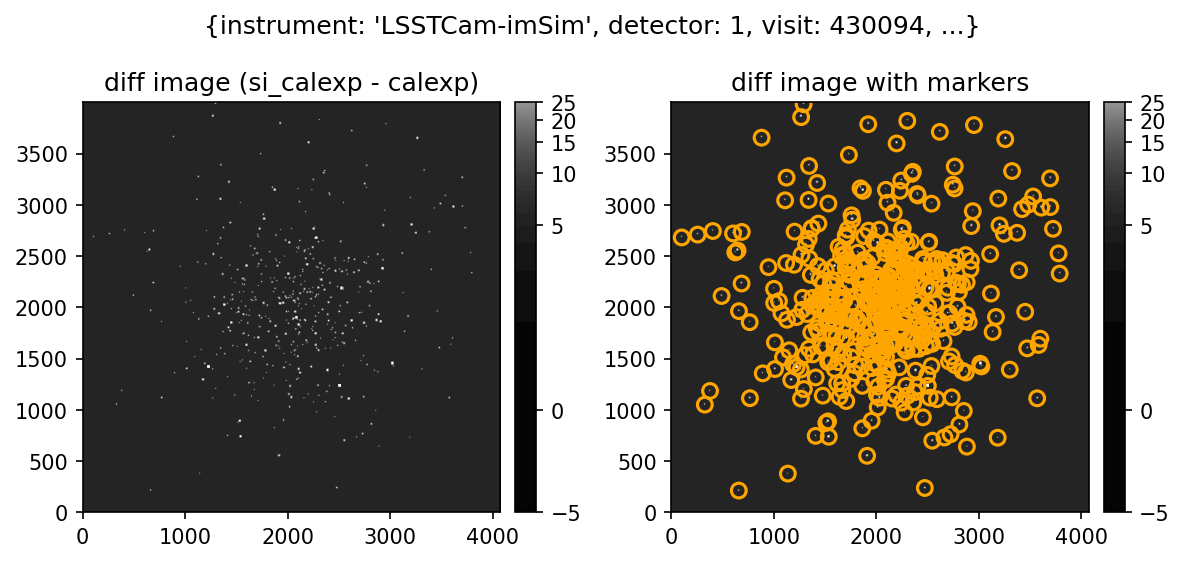

In [110]:
plot_diff_calexp_g = calexp_g.clone()
plot_diff_calexp_g.image.array = si_calexp_g.image.array - calexp_g.image.array

fig, ax = plt.subplots(1, 2, figsize=(8, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('asinh', min=-5/Q, max=25/Q, Q=Q)
display0.mtv(plot_diff_calexp_g.image)
plt.title('diff image (si_calexp - calexp)')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('asinh', min=-5/Q, max=25/Q, Q=Q)
display1.mtv(plot_diff_calexp_g.image)
plt.title('diff image with markers')
x, y = calexp.wcs.skyToPixelArray(si_cat_out_g['ra'], si_cat_out_g['dec'], degrees=True)
plt.scatter(x, y, marker='o', s=50, fc='none', ec='orange', lw=1.5)

plt.suptitle(str(dataId_g), y=0.8)
plt.tight_layout()
plt.show()

### Wrap all of the detection and measurement steps in a function.

The steps here follow the <a href="https://github.com/rubin-dp0/tutorial-notebooks/blob/main/05_Intro_to_Source_Detection.ipynb">Intro to Source Detection</a> tutorial notebook, so rather than explain them in detail here, we simply wrap all the steps in a single function that can be executed for each image.

In [106]:
def processFakes(calexp_inp, calexp_inp_new):
    
    # Create a basic schema to use with these tasks
    schema = afwTable.SourceTable.makeMinimalSchema()

    print('schema = ')
    print(schema)
    
    # Create a container which will be used to record metadata about algorithm execution
    algMetadata = dafBase.PropertyList()

    # Initialize CharacterizeImageTask and its configuration:
    config = CharacterizeImageTask.ConfigClass()
    config.psfIterations = 1
    charImageTask = CharacterizeImageTask(None, config=config)

    # Initialize SourceDetectionTask and its configuration:
    config = SourceDetectionTask.ConfigClass()
    config.thresholdValue = 5      # detection threshold in units of thresholdType
    config.thresholdType = "stdev"   # units for thresholdValue
    sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)
    sourceDeblendTask = SourceDeblendTask(schema=schema)

    # Initialize SingleFrameMeasurementTask and its configuration:
    config = SingleFrameMeasurementTask.ConfigClass()
    sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config, algMetadata=algMetadata)

    #print('after config, schema = ')
    #print(schema)

    # Make an empty table that we'll put the results in:
    tab = afwTable.SourceTable.make(schema)
    
    # Image characterization
#    I'm not sure what this does or if it is necessary, but it seems to take a long time - Brian Morsony, 7/29/2022
    result = charImageTask.run(calexp_inp_new)

    # Get the PSF and some image properties
    psf = calexp_inp_new.getPsf()
    # sigma = psf.computeShape().getDeterminantRadius()
    pixelScale = calexp_inp_new.getWcs().getPixelScale().asArcseconds()

    # The factor of 2.355 converts from std to fwhm
    sigma = 1./pixelScale/2.355
    print('psf fwhm = {:.2f} arcsec'.format(sigma*pixelScale*2.355))
    
    # Run source detection
    result = sourceDetectionTask.run(tab, calexp_inp_new)
    
    sources = result.sources

    del result

    sources = sources.copy(True)
    
    # Run source deblending
    sourceDeblendTask.run(calexp_inp_new, sources)

    # Run source measurement
    sourceMeasurementTask.run(measCat=sources, exposure=calexp_inp_new)
    
    # The copy makes sure that the sources are sequential in memory
    sources = sources.copy(True)
    
    # For convenience, return an Astropy table:
    source_tab = sources.asAstropy()
    
    # Convert fluxes to magnitudes and add them to the table
    photocalib = calexp_inp_new.getPhotoCalib()
    psfmags = photocalib.instFluxToMagnitude(sources, 'base_PsfFlux')
    source_tab.add_columns([psfmags[:,0], psfmags[:,1]], names=['mag_psf', 'magerr_psf'])
    
    return(source_tab)

### Run the "processFakes" function on each image that we injected fake stars into

**This may take at least a couple minutes to run**

In [111]:
#t1 = time.time()

#sources_withfakes_u = processFakes(calexp_orig_u,calexp_new_u)
sources_withfakes_g = processFakes(plot_calexp_g, plot_si_calexp_g)
#sources_withfakes_r = processFakes(calexp_orig_r,calexp_new_r)
sources_withfakes_i = processFakes(plot_calexp_i, plot_si_calexp_i)

#t2 = time.time()
#print('dt', t2 - t1)

schema = 
Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)



psf fwhm = 1.00 arcsec


schema = 
Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)



psf fwhm = 1.00 arcsec


In [112]:
sources_withfakes_g

id,coord_ra,coord_dec,parent,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_failed,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,deblend_peak_center_x,deblend_peak_center_y,deblend_peakId,deblend_nPeaks,deblend_parentNPeaks,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_near_edge,base_CircularApertureFlux_flag_badCentroid_near_edge,base_GaussianFlux_flag_badCentroid_near_edge,base_LocalBackground_flag_badCentroid_near_edge,base_NaiveCentroid_flag_badInitialCentroid_near_edge,base_PsfFlux_flag_badCentroid_near_edge,base_SdssShape_flag_badCentroid_near_edge,base_Variance_flag_badCentroid_near_edge,slot_Centroid_flag_near_edge,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_LocalBackground_flag_badCentroid_badError,base_NaiveCentroid_flag_badInitialCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,base_Variance_flag_badCentroid_badError,slot_Centroid_flag_badError,base_Blendedness_old,base_Blendedness_raw,base_Blendedness_raw_child_instFlux,base_Blendedness_raw_parent_instFl

In [113]:
# Coordinates of input fake stars
sc_fakes = SkyCoord(ra=radec_coords[0]*u.deg, dec=radec_coords[1]*u.deg, frame='icrs')

# Coordinates of objects in calexps with fakes added:
#sc_withfakes_u = SkyCoord(ra=sources_withfakes_u['coord_ra'], dec=sources_withfakes_u['coord_dec'], frame='icrs')
sc_withfakes_g = SkyCoord(ra=sources_withfakes_g['coord_ra'], dec=sources_withfakes_g['coord_dec'], frame='icrs')
#sc_withfakes_r = SkyCoord(ra=sources_withfakes_r['coord_ra'], dec=sources_withfakes_r['coord_dec'], frame='icrs')
sc_withfakes_i = SkyCoord(ra=sources_withfakes_i['coord_ra'], dec=sources_withfakes_i['coord_dec'], frame='icrs')
# Note that units weren't required for sc_withfakes_*, because it already has them.

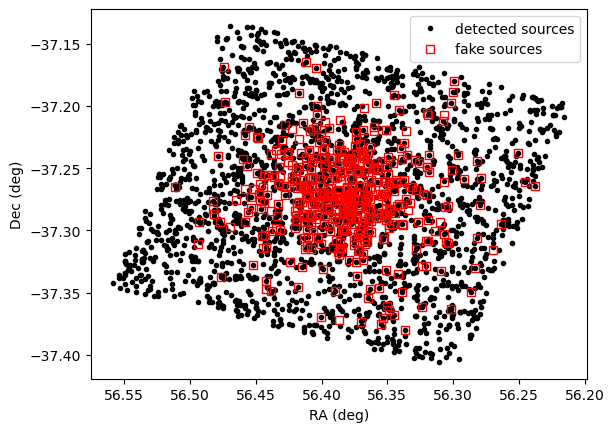

In [114]:
fig, ax = plt.subplots(1, 1)
plt.plot(sc_withfakes_g.ra, sc_withfakes_g.dec, '.k', label='detected sources')
plt.plot(sc_fakes.ra, sc_fakes.dec, 'sr', fillstyle='none', label='fake sources')
ax.invert_xaxis()
plt.legend()
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.show()

In [115]:
# Match them using the Astropy SkyCoord "match_to_catalog_sky" method:

#idx_u, sep_u, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_u)
idx_g, sep_g, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_g)
#idx_r, sep_r, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_r)
idx_i, sep_i, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_i)

In [116]:
okmch_g = (sep_g.arcsec < 1.0)
mch_mags_g = sources_withfakes_g[idx_g]['mag_psf']
mch_magerrs_g = sources_withfakes_g[idx_g]['magerr_psf']
mch_mags_g[~okmch_g] = -99.9
mch_magerrs_g[~okmch_g] = 99.9
seps_g = sep_g.arcsec

okmch_i = (sep_i.arcsec < 1.0)
mch_mags_i = sources_withfakes_i[idx_i]['mag_psf']
mch_magerrs_i = sources_withfakes_i[idx_i]['magerr_psf']
mch_mags_i[~okmch_i] = -99.9
mch_magerrs_i[~okmch_i] = 99.9
seps_i = sep_i.arcsec

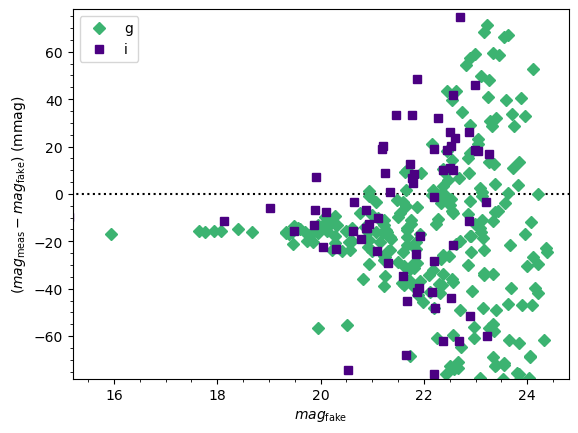

In [117]:
fig = plt.plot(figsize=(9, 9))

plt.hlines(0, 0, 30, linestyle=':', color='Black')
plt.plot(g_ext[okmch_g], 1000.0 * (mch_mags_g[okmch_g] - g_ext[okmch_g]),
         'D', ms=6, color='mediumseagreen', label='g')
plt.plot(i_ext[okmch_i], 1000.0 * (mch_mags_i[okmch_i] - i_ext[okmch_i]),
         's', ms=6, color='indigo', label='i')
plt.legend()
plt.xlabel(r'$mag_{\rm fake}$')
plt.ylabel(r'$(mag_{\rm meas} - mag_{\rm fake})$ (mmag)')
plt.xlim(15.2, 24.8)
plt.ylim(-78, 78)
plt.minorticks_on()
plt.show()

In [ ]:
plt.hist(sep_g.arcsec, bins=100)
plt.show()

In [ ]:
plt.hist(g_ext-ssp.mags['LSST_g'], bins=20)
plt.show()

## Code scraps

In [50]:
cen = wcs.pixelToSky(boxcen)
sc_cen = SkyCoord(ra=cen[0].asDegrees()*u.deg, dec=cen[1].asDegrees()*u.deg)
print(cen, sc_cen)

(56.3850820541, -37.2710984098) <SkyCoord (ICRS): (ra, dec) in deg
    (56.38508205, -37.27109841)>


In [48]:
c0 = cen[0]
c0.asDegrees()

56.38508205405538

In [56]:
racen = []
deccen = []
sepcen = []
band = []

for ref in calexp_DatasetRefs:
    dataId = ref.dataId
    bbox_tmp = butler.get('calexp.bbox', dataId=dataId)
    wcs_tmp = butler.get('calexp.wcs', dataId=dataId)
    radec_cen = wcs_tmp.pixelToSky(bbox_tmp.getCenterX(), bbox_tmp.getCenterY())
    sc_cen_tmp = SkyCoord(ra=radec_cen[0].asDegrees()*u.deg, dec=radec_cen[1].asDegrees()*u.deg)
    racen.append(radec_cen[0].asDegrees())
    deccen.append(radec_cen[0].asDegrees())
    sepcen.append(sc_cen_tmp.separation(sc_cen))
    band.append(dataId['band'])
    #print(radec_cen)

In [60]:
for i in range(len(racen)):
    print(band[i], racen[i], deccen[i], sepcen[i].arcmin)

g 57.63643963839649 57.63643963839649 70.54827440211709
i 56.4171830028419 56.4171830028419 43.16022221107452
g 57.1316882083597 57.1316882083597 45.01235402602625
i 56.60928245066372 56.60928245066372 90.27334847657139
i 56.73952386922587 56.73952386922587 35.12614947199311
i 56.434814087886025 56.434814087886025 36.70019432135377
g 55.52034051321347 55.52034051321347 95.76943154368364
i 56.47408169052066 56.47408169052066 24.052281553604367
g 56.758055636256294 56.758055636256294 36.468960055010285
i 56.26073297040845 56.26073297040845 8.680688658363604
i 56.9531128491698 56.9531128491698 67.11843170795788
i 57.74561214902929 57.74561214902929 119.02581483001784
g 56.57018708815062 56.57018708815062 16.610361754451926
i 55.692745706452975 55.692745706452975 71.99215307483627
g 56.38508205405538 56.38508205405538 0.0
i 56.634361762076416 56.634361762076416 83.29047343010313
i 56.31855780579958 56.31855780579958 53.70835666334618
i 57.31994121773368 57.31994121773368 45.5474505771269
i

In [59]:
sepcen[0].arcmin

70.54827440211709

In [ ]:
np.random.seed(0)

nsource = 100

In [ ]:
x_lim = np.random.uniform(0, calexp.getBBox().endX, nsource)
y_lim = np.random.uniform(0, calexp.getBBox().endY, nsource)
ra_lim, dec_lim = calexp.wcs.pixelToSkyArray(x_lim, y_lim, degrees=True)

mag = np.random.uniform(15, 25, nsource)
# Sersic index
n = np.random.uniform(0.5, 4, nsource)
# major-to-minor axis ratio
q = np.random.uniform(0.5, 1, nsource)
# position angle of the object (in degrees)
beta = np.random.uniform(0, 180, nsource)

semimajor = np.random.uniform(1, 10, nsource)
half_light_radius = np.sqrt(semimajor**2 / q)

In [ ]:
si_cat = Table({
    'injection_id': np.arange(nsource),
    'ra': ra_lim, 'dec': dec_lim,
    'source_type': ['Sersic']*nsource,
    'mag': mag, 'n': n, 'q': q, 'beta': beta,
    'half_light_radius': half_light_radius})

display(si_cat[:5])

In [ ]:
# Central (RA, Dec) position (in degrees) at which to insert stars:
racen = 56.39
deccen = -37.275

# Place all the fake stars within `scatter_arcmin` arcminutes of the center coordinate:
scatter_arcmin = 1.0

# "nfakes" is the number of fake stars to inject:
nfakes = 131

np.random.seed(715)   # make it reproducable, not random

# Assign positions using a (random) normal distribution about the center coordinates:
fake_ras = racen + (np.random.randn(nfakes) * scatter_arcmin / 60.0)
fake_decs = deccen + (np.random.randn(nfakes) * scatter_arcmin / 60.0)

# Make artificial u magnitudes in a range:
min_umag = 19.0
max_umag = 23.0
mag_scatter = 0.3
fake_umags = np.linspace(min_umag, max_umag, nfakes)

# Now assign magnitudes in other bands using (~fixed) colors:
fake_gmags = fake_umags - (1.0 + mag_scatter * np.random.randn(nfakes))  # distrib centered on u-g=1.0
fake_rmags = fake_gmags - (0.4 + mag_scatter * np.random.randn(nfakes))  # distrib centered on g-r=0.4
fake_imags = fake_rmags - (0.2 + mag_scatter * np.random.randn(nfakes))  # distrib centered on r-i=0.2

# These are totally arbitrary colors, but should be kinda similar to BHB stars?

In [ ]:
si_cat_stars = Table({'injection_id': np.arange(nfakes),
                      'ra': fake_ras, 'dec': fake_decs,
                      'source_type': ['DeltaFunction']*nfakes,
                      'g_mag': fake_gmags, 'i_mag': fake_imags,
                      'mag': fake_gmags,
                     })

# Start by creating a dataframe with the fake dwarf data, setting all source_types to "star":

#input_catalogue = pd.DataFrame(dict(
#    ra=fake_ras,
#    dec=fake_decs,
#    g_mag=fake_gmags,
#    i_mag=fake_imags,
#    source_type="star",
#))

display(si_cat_stars[:5])